# Camera Calibration
    I'll compute the camera calibration using chessboard images
    Here are some pictures given used to calibrate the camera.
    Just show them to you.
    including pinhole and fisheye calibration
    

### pinhole calibration
    Step1:采集若干张图片
    Step2:基于图片计算摄像头内参和外参
    Step3:取出摄像头实际工作环境的外参,这里由于我默认只求地面的点,则应该取图片平放置地面的那组参数
    Step4:基于求出的dist内参,对目标图像坐标变换得到去畸变坐标u,v
    Step5:基于u,v求出对应世界坐标(x,y),这里使用了单适性算子,相关见下链接.
    Step6:坐标变换一下(世界坐标系平移)
    https://blog.csdn.net/u010128736/article/details/52860364


In [1]:
import os
import cv2
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import math as mt
%matplotlib inline

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.00001)
find_flag = cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE
calib_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW

global mtx, dist

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = 40*np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = []

# Make a list of calibration images
images = glob.glob('./calibration/b*.jpg')

# Step through the list and search for chessboard corners
for i in range(len(images)):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print(images[i],ret)
    
    # If found, add object points, image points
    if ret == True:
        cv2.cornerSubPix(gray,corners,(15,15),(1,-1),criteria)
        imge = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        img_with_corners.append(imge)
        objpoints.append(objp)
        imgpoints.append(corners)

./calibration\b10.jpg True
./calibration\b11.jpg True
./calibration\b12.jpg True
./calibration\b13.jpg True
./calibration\b14.jpg True
./calibration\b15.jpg True
./calibration\b2.jpg True
./calibration\b21.jpg True
./calibration\b22.jpg True
./calibration\b23.jpg True
./calibration\b24.jpg True
./calibration\b26.jpg True
./calibration\b27.jpg True
./calibration\b28.jpg True
./calibration\b29.jpg True
./calibration\b3.jpg True
./calibration\b30.jpg True
./calibration\b31.jpg True
./calibration\b32.jpg True
./calibration\b35.jpg True
./calibration\b36.jpg True
./calibration\b37.jpg True
./calibration\b4.jpg True
./calibration\b5.jpg True
./calibration\btest.jpg True
./calibration\btest2.jpg True


In [3]:
# calculate the initial matrix and distort parameters, the extrinsic rvecs and tvecs

img = cv2.imread('calibration/btest.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print("dist",dist)
print("mtx",mtx)
# print("rvecs",np.array(rvecs).transpose())
# print("tvecs",np.array(tvecs).transpose())

def cal_undistort(img):
    # convert image into gray scale
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

dist [[ 0.03198769 -0.06374828  0.00049138  0.0008496   0.02293117]]
mtx [[1.14495061e+03 0.00000000e+00 1.04862542e+03]
 [0.00000000e+00 1.14684940e+03 4.58871150e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [4]:
# estimate the accuracy of the calibration
# by calculating the Standard Deviation

imgpoints2=[]
for i in range(len(objpoints)):
    imgpoint,jacobian=cv2.projectPoints(objpoints[i],np.array(rvecs)[i],np.array(tvecs)[i],mtx,dist,0)
    imgpoints2.append(imgpoint)
    
average_d_square=0
for i in range(len(objpoints)):
    temp=np.array(imgpoints[i])-np.array(imgpoints2[i])
    temp=pow(temp,2)
    average_d_square+=np.sqrt(np.sum(temp))/54
#     print(np.sqrt(np.sum(temp))/54)
print ("average_d_square:",average_d_square/len(objpoints))

average_d_square: 0.08456953553392675


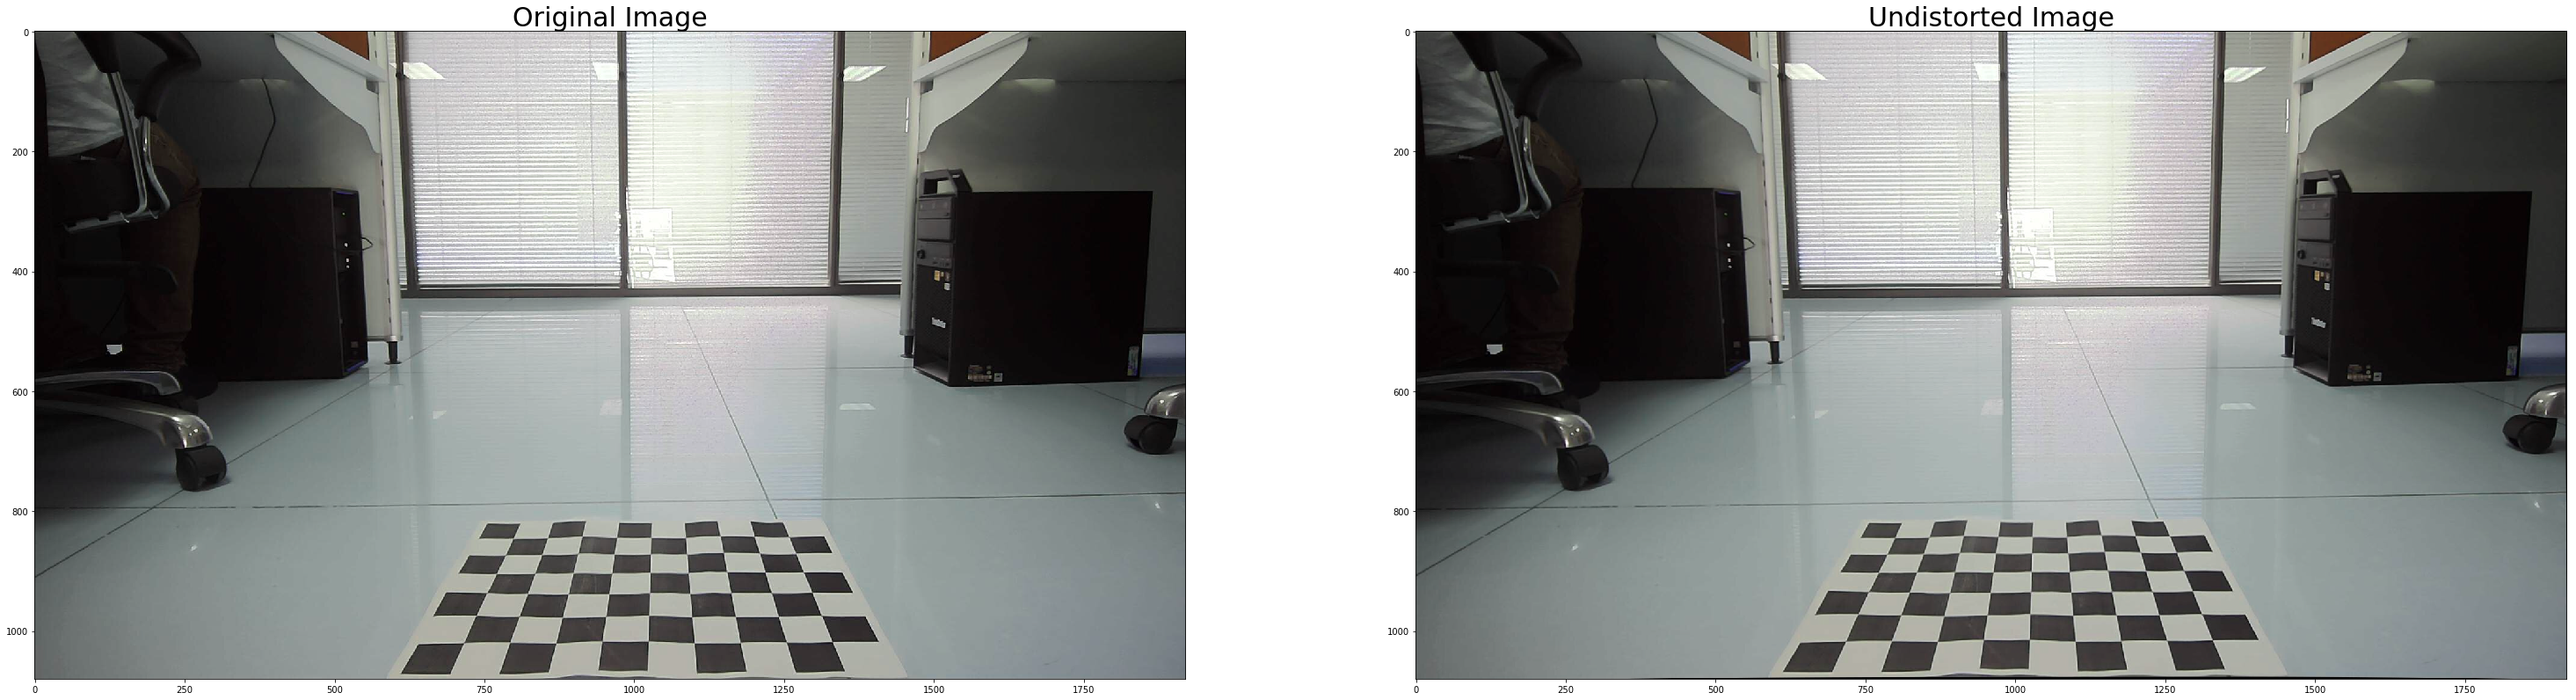

In [5]:
img = cv2.imread('calibration/btest.jpg')
undist = cal_undistort(img)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# transfer u,v to xc,yc to xw,yw

# Compensation parameter
y=-80
x=-150

# catch the need extrinsic and intrinsic parameters
rvec_test=rvecs[21]
tvec_test=np.mat(tvecs[21])
tpts=np.array([[1223.43,783.637,1],[196.872,798.733,1],[581.359,569.328,1],[797.051,445.043,1],[1070.7,442.586,1]])
apts=np.array([[0,800,1],[-800,800,1],[-800,1600,1],[-800,3400,1],[0,3400,1]])
mtx_test=np.hstack((mtx,np.mat([0,0,0]).T))

# calculate the KRT(单适性矩阵)
rmat,_ =cv2.Rodrigues(rvec_test)
RT=np.hstack((rmat,tvec_test))
KRT=np.vstack((RT,[0,0,0,1]))

# calculate the xw,yw
temp = KRT
temp=np.delete(temp,2,axis=1)
temp=np.delete(temp,3,axis=0)
temp=mtx*temp
tempI=temp.I

stemp=np.array(tempI*tpts.T).T

results=[]
for i in range(len(stemp)):
    TTemp=stemp[i]/stemp[i][2]
    TTemp[0] = (TTemp[0]-300)
    TTemp[1] = (TTemp[1]+80-800)*-1
    results.append(TTemp)
print(np.mat(results))


[[ 1.40605864e+01  8.26844773e+02  1.00000000e+00]
 [-7.87220237e+02  8.12000037e+02  1.00000000e+00]
 [-8.23765902e+02  1.65284854e+03  1.00000000e+00]
 [-8.78896825e+02  3.44611287e+03  1.00000000e+00]
 [-4.01463683e+01  3.47365313e+03  1.00000000e+00]]


### fisheye calibration
    基于cv2.fisheye对相机进行标定,但是一次标定结果标准差误差近似3像素，
    对其二次标定，基于针孔相机标定方法标定，标准差误差降低为0.07．
    
    Step1:采集若干张图片
    Step2:基于图片利用cv2.fisheye.calibrate计算摄像头内参(外参用不到，还有不少误差)
    Step3:基于鱼眼内参对图像进行undistort，基于undistort_img进行标定，得到需要的内外参
        　（对比鱼眼内外参和二次标定内外参结果有细微差别，但这一点点就是误差校正量）
    Step4:取出摄像头实际工作环境的外参,这里由于我默认只求地面的点,则应该取图片平放置地面的那组参数
    Step5:基于求出的dist内参,对目标图像坐标变换得到去畸变坐标u,v
    Step6:基于u,v求出对应世界坐标(x,y),这里使用了单适性算子.
    Step7:坐标变换一下(世界坐标系平移)

In [2]:
# input fisheye imgs, catch objpoints and imgpoints, the same as pinhole camera
  
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, 6 * 9, 3), np.float32)
objp[0,:,:2] = 40*np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = []

# Make a list of calibration images
images = glob.glob('./other/8*.jpg')

# Step through the list and search for chessboard corners
for i in range(len(images)):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)#find_flag
    print(images[i],ret)
    # If found, add object points, image points
    if ret == True:  
        cv2.cornerSubPix(gray,corners,(15,15),(-1,-1),criteria)
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        img_with_corners.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)

./other\8 (1).jpg True
./other\8 (10).jpg True
./other\8 (11).jpg True
./other\8 (12).jpg True
./other\8 (13).jpg True
./other\8 (14).jpg True
./other\8 (15).jpg True
./other\8 (16).jpg True
./other\8 (17).jpg True
./other\8 (18).jpg True
./other\8 (19).jpg True
./other\8 (20).jpg True
./other\8 (21).jpg True
./other\8 (22).jpg True
./other\8 (23).jpg True
./other\8 (24).jpg True
./other\8 (25).jpg True
./other\8 (26).jpg True
./other\8 (27).jpg True
./other\8 (28).jpg True
./other\8 (29).jpg True
./other\8 (3).jpg True
./other\8 (30).jpg True
./other\8 (31).jpg True
./other\8 (32).jpg True
./other\8 (33).jpg True
./other\8 (34).jpg True
./other\8 (35).jpg True
./other\8 (36).jpg True
./other\8 (37).jpg True
./other\8 (38).jpg True
./other\8 (39).jpg True
./other\8 (40).jpg True
./other\8 (41).jpg True
./other\8 (42).jpg True
./other\8 (43).jpg True
./other\8 (44).jpg True
./other\8 (45).jpg True
./other\8 (46).jpg True
./other\8 (47).jpg True
./other\8 (48).jpg True
./other\8 (49).jpg

In [3]:
# calculate the internal parameters by cv2.fisheye.calibrate． 
# Extrinsic parameter is useless

num = len(objpoints)
mtxfish = np.zeros((3, 3))
distfish = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float32) for i in range(num)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float32) for i in range(num)]
img = cv2.imread('calibration/RT.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = gray.shape[::-1]

rms, mtxfish,distfish, rvecs, tvecs = cv2.fisheye.calibrate(objpoints, imgpoints, img_size, mtxfish,distfish, rvecs, tvecs, calib_flags, criteria)

print("dist",distfish)
print("mtx",mtxfish)
# print("rvecs",np.array(rvecs).transpose())
# print("tvecs",np.array(tvecs).transpose())

dist [[-0.0284132 ]
 [-0.03371846]
 [ 0.0325395 ]
 [-0.01456839]]
mtx [[961.6197901    0.         956.48660051]
 [  0.         969.83080187 585.1942164 ]
 [  0.           0.           1.        ]]


In [4]:
# undist imgs and based on undist_imgs to try calibration

def __get_short_name(fname):
    """该函数用于获取文件前缀名，输入包含路径的全名"""
    fpath, tempfname = os.path.split(fname)
    shortname, extension = os.path.splitext(tempfname)  
    return shortname

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = 40*np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = []

# Make a list of calibration images
images = glob.glob('./other/8*.jpg')

# Step through the list and search for chessboard corners
for i in range(len(images)):
    img = cv2.imread(images[i])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtxfish, distfish, np.eye(3), mtxfish, img_size, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT)
    gray = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
#     print(images[i],ret)
    
    # If found, add object points, image points
    if ret == True:
        cv2.cornerSubPix(gray,corners,(15,15),(1,-1),criteria)
        imge = cv2.drawChessboardCorners(undistorted_img, (9,6), corners, ret)
        img_with_corners.append(imge)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #去畸变图片存储
        shortname = __get_short_name(images[i])    # 获取文件前缀
        dst_fname = './calibration/undistort_img' + '/' + shortname + '.jpg'
        cv2.imwrite(dst_fname, imge)     # 生成图片

In [5]:
# calculate the internal parameters and extrinsic parameters....

img = cv2.imread('calibration/undistort_img/cRT.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

print("dist",dist)
print("mtx",mtx)
# print("rvecs",np.array(rvecs).transpose())
# print("tvecs",np.array(tvecs).transpose())

dist [[ 0.01456203 -0.01647693 -0.00426784  0.00130388  0.00922871]]
mtx [[975.61113921   0.         963.1083537 ]
 [  0.         984.68215987 561.4349962 ]
 [  0.           0.           1.        ]]


In [6]:
imgpoints2=[]
for i in range(len(objpoints)):
    imgpoint,_=cv2.projectPoints(objpoints[i],np.array(rvecs)[i],np.array(tvecs)[i],mtx,np.array([[0.,0.,0.,0.,0.]]),0)
#     imgpoint,_=cv2.projectPoints(objpoints[i],np.array(rvecs)[i],np.array(tvecs)[i],mtx,dist,0)
    imgpoints2.append(imgpoint)
    
imgpoints3 = []
for points in imgpoints:
    imgpoints3.append(cv2.undistortPoints(points,mtx,dist,None,mtx))
    
average_d_square=0
for i in range(len(objpoints)):
    temp=np.array(imgpoints3[i])-np.array(imgpoints2[i])
    temp=pow(temp,2)
    average_d_square+=np.sqrt(np.sum(temp))/54
#     print(np.sqrt(np.sum(temp))/54)
print ("average_d_square:",average_d_square/len(objpoints))

average_d_square: 0.04566221723972591


In [7]:
# undist imgs and based on undist_imgs to try calibration
def __get_short_name(fname):
    """该函数用于获取文件前缀名，输入包含路径的全名"""
    fpath, tempfname = os.path.split(fname)
    shortname, extension = os.path.splitext(tempfname)  
    return shortname

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((3 * 4, 3), np.float32)
objp[:,:2] = 900*np.mgrid[0:4, 0:3].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
img = cv2.imread('./other/crt.jpg')
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtxfish, distfish, np.eye(3), mtxfish, img_size, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT)
gray = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4,3), None)
print(ret)

# If found, add object points, image points
if ret == True:
    cv2.cornerSubPix(gray,corners,(15,15),(1,-1),criteria)
    imge = cv2.drawChessboardCorners(undistorted_img, (4,3), corners, ret)

    #去畸变图片存储
    dst_fname = './other/undistort_img/crt.jpg'
    cv2.imwrite(dst_fname, imge)     # 生成图片

True


In [8]:
#采点误差修正
corners[0]=[1214.56,649.829]
corners[2]=[848.306,659.974]
corners[1]=[1034.87,655.358]
corners[3]=[670.579,663.482]
other = cv2.drawChessboardCorners(cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT), (4,3), corners, ret)
cv2.imwrite('./other/undistort_img/crt_improve.jpg', other)
retval,rvec,tvec = cv2.solvePnP(objp, corners, mtx, dist)

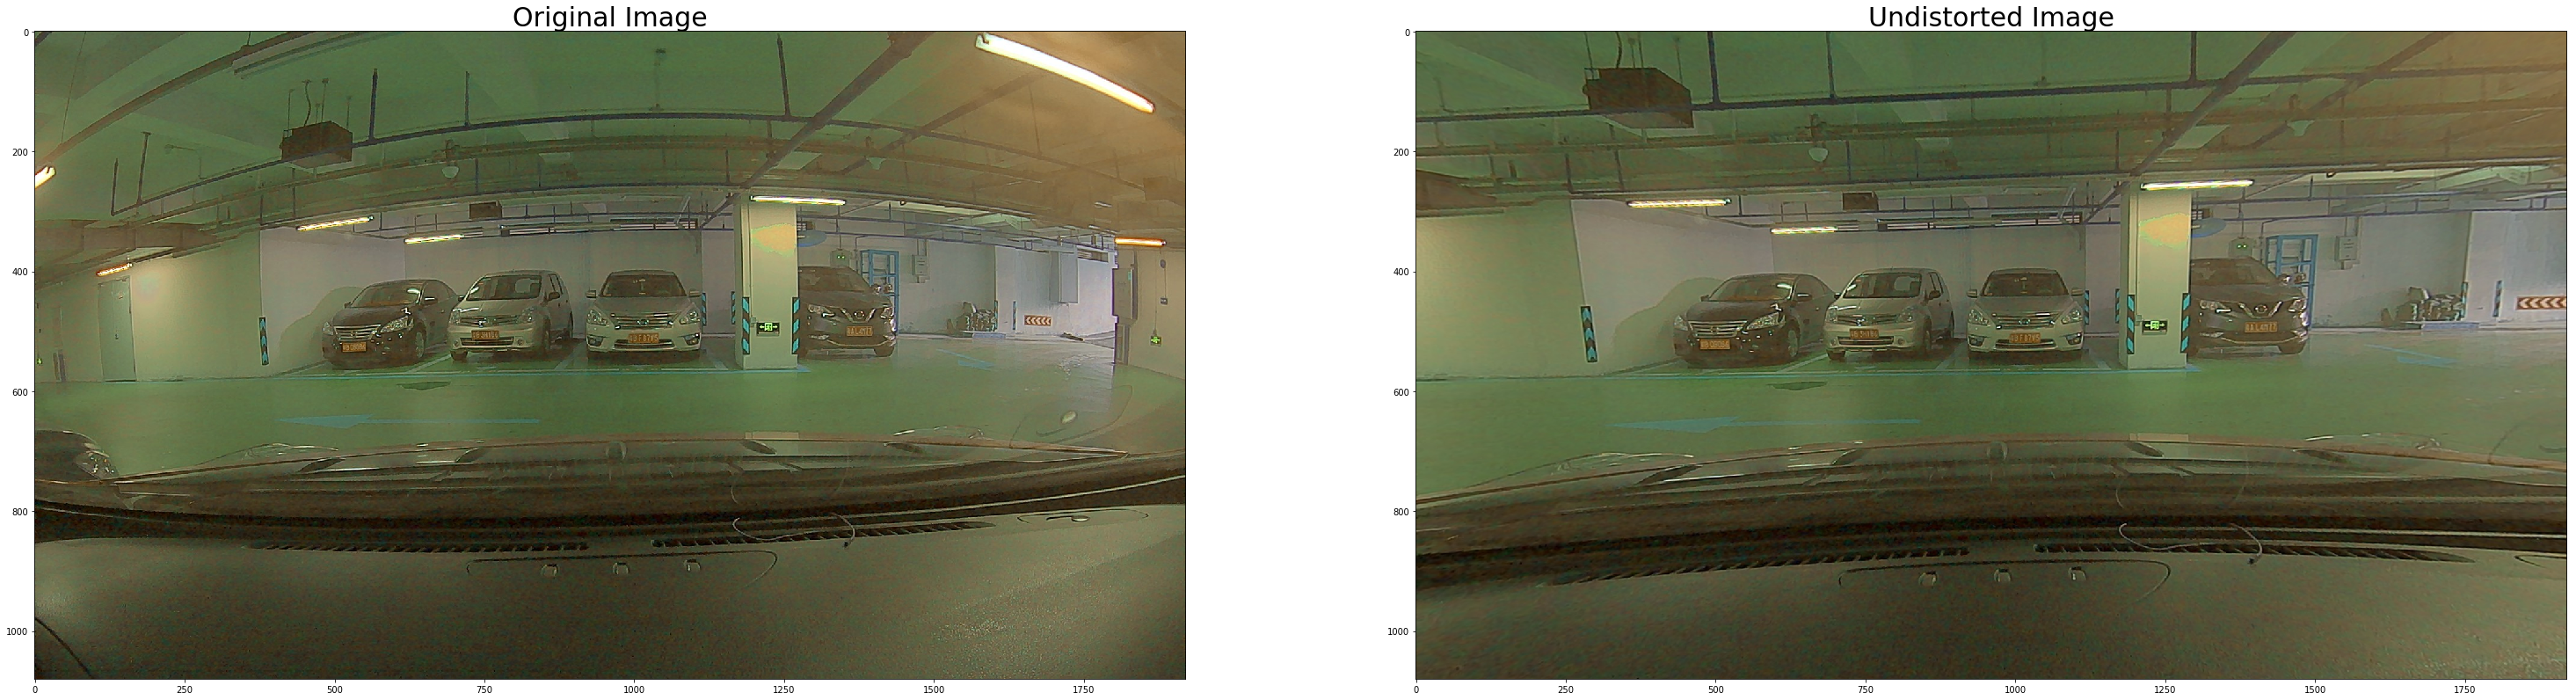

In [9]:
img = cv2.imread('./other/test.jpg')
undist =  cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT)
cv2.imwrite('./other/undistort_img/test.jpg', undist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
x=-950-200-20
y=5250-1660-100

rvec_test=rvec
tvec_test=np.mat(tvec)
tpts=np.array([[741.994,563.667,1],[885.27,561.014,1],[1008.4,562.039,1],[1161.21,564.551,1],[907,628,1]])
apts=np.array([[-15-1100-1250,8270,1],[-15-1100,8270,1],[-15,8270,1],[-15+1250,8270-155,1],[-380.657,4182.71,1]])
mtx_test=np.hstack((mtx,np.mat([0,0,0]).T))

rmat,_ =cv2.Rodrigues(rvec_test)
RT=np.hstack((rmat,tvec_test))
KRT=np.vstack((RT,[0,0,0,1]))

temp = KRT
temp=np.delete(temp,2,axis=1)
temp=np.delete(temp,3,axis=0)
temp=mtx*temp
tempI=temp.I
# print("rvec_test",rvec_test)
# print("tvec_test",tvec_test)
# print("mtx_test",mtx_test)
# print("rmat",rmat)
# print("KRT",KRT)
print("temp",temp)
# print("tempI",tempI)

#图像转世界
stemp=np.array(tempI*tpts.T).T
# print(stemp)
results=[]
for i in range(len(stemp)):
    TTemp=stemp[i]/stemp[i][2]
    TTemp[0] = -(TTemp[0]+x)
    TTemp[1] = (TTemp[1]+y)
    results.append(TTemp)
print(np.mat(results))

#世界转图像
results=[]
for i in range(len(apts)):
    TTemp=apts[i]
    TTemp[0]=-1*(TTemp[0]-1190)
    TTemp[1]-=3490
    TTemp=temp*np.array([TTemp]).T
    TTemp/=TTemp[2]
    results.append(TTemp)
np.array(results).T
# tpts=np.array([[741.994,563.667,1],[885.27,561.014,1],[1008.4,562.039,1],[1161.21,564.551,1],[907,628,1]])
# apts=np.array([[-15-1100-1250,8270,1],[-15-1100,8270,1],[-15,8270,1],[-15+1250,8270-155,1],[-380.657,4182.71,1]])

temp [[-9.59492170e+02  9.63978768e+02  5.83840728e+06]
 [ 3.49621901e+01  4.07315309e+02  3.12656526e+06]
 [ 1.62537773e-02  9.88608159e-01  4.80489957e+03]]
[[-1.95905593e+03  6.81776253e+03  1.00000000e+00]
 [-7.54797787e+02  6.75318987e+03  1.00000000e+00]
 [ 2.54622088e+02  6.52170567e+03  1.00000000e+00]
 [ 1.41377753e+03  6.19329172e+03  1.00000000e+00]
 [-3.97366320e+02  4.18258545e+03  1.00000000e+00]]


array([[[7.33736262e+02, 8.60647207e+02, 9.72775522e+02, 1.10275767e+03,
         9.06420242e+02],
        [5.42104612e+02, 5.38688121e+02, 5.35669585e+02, 5.34190314e+02,
         6.28009948e+02],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00]]])

In [72]:
# 别人代码,用于代码测试
# 根据实际情况,yolo应该是针对鱼眼矫正后的图像做检测,即实际yolo返回结果为矫正后的点坐标,
# 则这里先对图像做去畸变,再在去畸变的图像上做处理,去畸变后图像存于undistort_img
# undist fish
def __get_short_name(fname):
    """该函数用于获取文件前缀名，输入包含路径的全名"""
    fpath, tempfname = os.path.split(fname)    # 分割文件名与路径
    shortname, extension = os.path.splitext(tempfname)    # 分割文件名与扩展名
    return shortname

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 8, 3), np.float32)
objp[:,:2] = 108.4*np.mgrid[0:8, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = []

# Make a list of calibration images
images = glob.glob('./back/undistort_img/*.JPG')

# Step through the list and search for chessboard corners
for i in range(len(images)):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    # If found, add object points, image points
    if ret == True:
        cv2.cornerSubPix(gray,corners,(15,15),(1,-1),criteria)
        imge = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        img_with_corners.append(imge)
        objpoints.append(objp)
        imgpoints.append(corners)
        print(images[i],ret)
        
img = cv2.imread('back/undistort_img/RT.JPG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print("dist",dist)
print("mtx",mtx)

imgpoints2=[]
for i in range(len(objpoints)):
    imgpoint,_=cv2.projectPoints(objpoints[i],np.array(rvecs)[i],np.array(tvecs)[i],mtx,dist,0)
    imgpoints2.append(imgpoint)
    
aaaa=0
for i in range(len(objpoints)):
    temp=np.array(imgpoints[i])-np.array(imgpoints2[i])
    temp=pow(temp,2)
    aaaa+=np.sqrt(np.sum(temp))/54
#     print(np.sqrt(np.sum(temp))/54)
print ("average_d_square:",aaaa/len(objpoints))

img = cv2.imread('./back/undistort_img/RT.JPG')
undist = undist = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

./back/undistort_img/3390.JPG True
./back/undistort_img/4200.JPG True
./back/undistort_img/75.JPG True


KeyboardInterrupt: 